In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spotifyclassification/data.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc,accuracy_score
import warnings 

In [3]:
warnings.filterwarnings(action = 'ignore')

In [4]:
data = pd.read_csv('/kaggle/input/spotifyclassification/data.csv').drop('Unnamed: 0',axis = 1)

data.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


In [5]:
df = data.copy()

In [6]:
df.isna().sum()

acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
target              0
song_title          0
artist              0
dtype: int64

# EDA

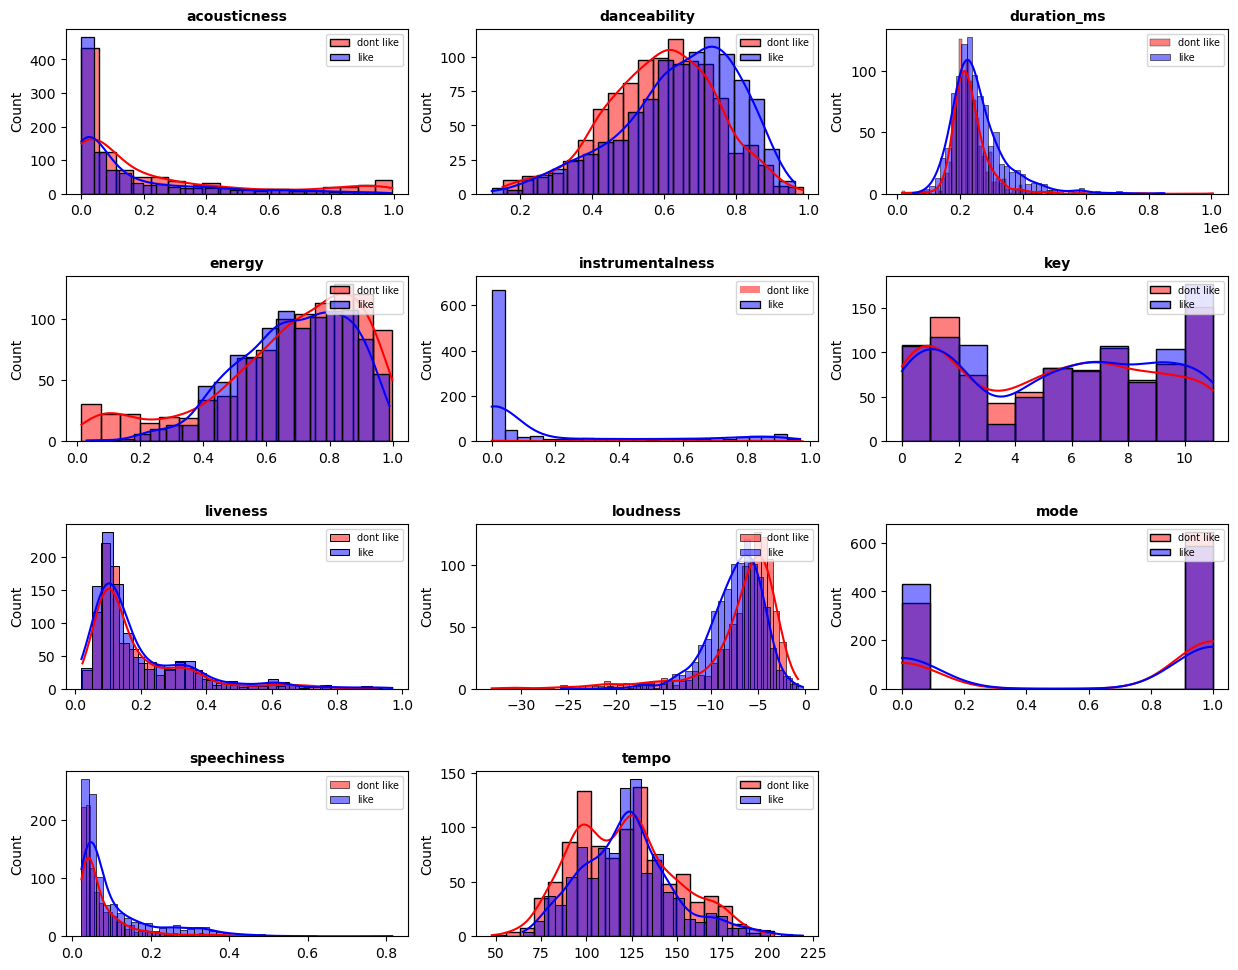

In [7]:
plt.figure(figsize = [15,15])
plt.subplots_adjust(hspace = 0.5)

cols = df.describe().columns.tolist()[:-3]

i = 1

for _ in cols:
    
    plt.subplot(5,3,i)
    
    sns.histplot(data = df[df['target'] == 0],
                 x = _,
                 color = 'red',
                 kde = True,
                 alpha = 0.5,
                 label = 'dont like')
    sns.histplot(data = df[df['target'] == 1],
                 x = _,
                 color = 'blue',
                 kde = True,
                 alpha = 0.5,
                 label = 'like')
    
    plt.title(_,size = 10,weight = 'bold')
    plt.legend(loc = 'upper right', prop = {'size':7})
    plt.xlabel('')    
    i += 1 

### He seems to prefer dance music and not too loud music.

# Data Preprocessing

In [8]:
def scaler(x):
    return (x - min(x)) / (max(x) - min(x))

In [9]:
cols = df.describe().columns.tolist()[:-1]

for _ in cols:
    df[_] = scaler(df[_])

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
acousticness,2017.0,0.188530,0.261296,0.0,0.009676,0.063615,0.266330,1.0
danceability,2017.0,0.575895,0.186809,0.0,0.454756,0.590487,0.714617,1.0
duration_ms,2017.0,0.232923,0.082928,0.0,0.186097,0.215681,0.257227,1.0
energy,2017.0,0.678170,0.213866,0.0,0.557567,0.712164,0.845403,1.0
instrumentalness,2017.0,0.136563,0.279879,0.0,0.000000,0.000078,0.055328,1.0
key,2017.0,0.485690,0.331658,0.0,0.181818,0.545455,0.818182,1.0
liveness,2017.0,0.181061,0.163600,0.0,0.077352,0.113871,0.240160,1.0
loudness,2017.0,0.793272,0.114720,0.0,0.753370,0.818817,0.864623,1.0
mode,2017.0,0.612295,0.487347,0.0,0.000000,1.000000,1.000000,1.0
speechiness,2017.0,0.087734,0.113421,0.0,0.018161,0.040106,0.107075,1.0


In [11]:
df = df.drop(['song_title','artist'],axis = 1) 
# I'm not going to use sont_title,artist

In [12]:
x_train,y_train,x_test,y_test = train_test_split(df.drop('target',axis = 1), df['target'], random_state = 42,
                                                 test_size = 0.2)

# Modeling

* i will use RFECV to select the appropriate variables.

### feature selection

In [13]:
cols = x_train.columns

RFE_CV = RFECV(estimator = LogisticRegression(), cv = 10, step = 1, scoring = 'accuracy')

RFE_CV.fit(x_train,x_test)

RFECV(cv=10, estimator=LogisticRegression(), scoring='accuracy')

Optimal number of features: 6
features list : ['acousticness', 'danceability', 'duration_ms', 'instrumentalness', 'loudness', 'speechiness']


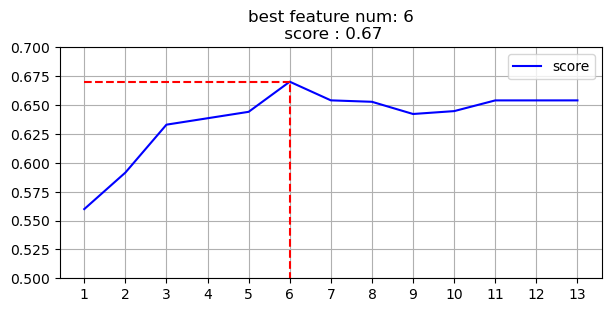

In [14]:
num = range(1,len(RFE_CV.grid_scores_)+1)
score = np.mean(RFE_CV.grid_scores_,axis = 1)
                
fig = plt.figure(figsize = [7,3])

ax = fig.add_subplot(111)

ax.plot(num,score,'b', label = 'score')
ax.set_xticks(ticks = np.arange(1,14));
ax.grid()
ax.plot([np.argmax(score)+1,np.argmax(score)+1],[0,max(score)], 'r--')
ax.plot([1,np.argmax(score)+1],[np.max(score),np.max(score)], 'r--')
ax.legend()
ax.set_ylim([0.5,0.7])


ax.set_title(f'best feature num: {np.argmax(score)+1}\n score : {round(max(score),2)}')

print('Optimal number of features:',RFE_CV.n_features_)
print('features list :',list(cols[RFE_CV.support_]))

In [15]:
x_train = x_train[list(cols[RFE_CV.support_])]
y_train = y_train[list(cols[RFE_CV.support_])]

In [16]:
logist = LogisticRegression()
logist.fit(x_train,x_test)

proba = logist.predict_proba(y_train)[:,1]
fpr,tpr,thr = roc_curve(y_test,proba)

area = round(auc(fpr,tpr),2)

Text(0.5, 1.0, 'True Positive Rate : 0.66\n False Positive Rate : 0.3')

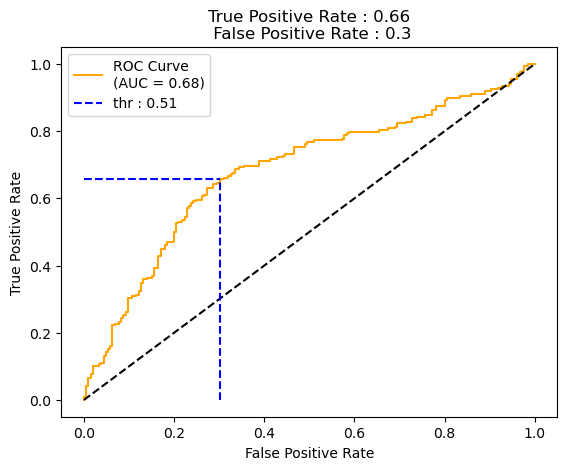

In [17]:
plt.plot(fpr,tpr, c = 'orange',label = f'ROC Curve\n(AUC = {area})')
plt.plot([0,1],[0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

idx = np.min(np.where(tpr > 0.65))

plt.plot([0,fpr[idx]],[tpr[idx],tpr[idx]],'b--')
plt.plot([fpr[idx],fpr[idx]],[0,tpr[idx]],'b--', label = f'thr : {round(thr[idx],2)}')
plt.legend()

plt.title(f'True Positive Rate : {round(tpr[idx],2)}\n False Positive Rate : {round(fpr[idx],2)}')

In [18]:
print(f'Threshold:{thr[idx]}')
print(f'True Positive Rate:{round(tpr[idx],2)}\n False Positive: rate:{round(fpr[idx],2)}')

Threshold:0.5065560417859454
True Positive Rate:0.66
 False Positive: rate:0.3


<AxesSubplot:>

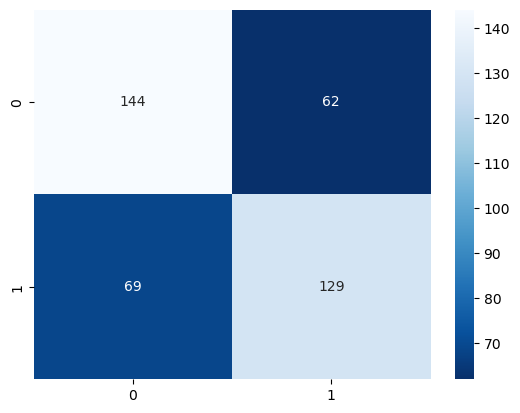

In [19]:
predict = (logist.predict_proba(y_train)[:,1] > 0.5065560417859454).astype(int)


sns.heatmap(confusion_matrix(y_test,predict), annot = True, fmt = 'g',
           cmap ='Blues_r')

In [20]:
coef = logist.coef_[0]
odds = np.exp(coef)
index = x_train.columns

In [21]:
pd.DataFrame({'coefficient':coef,
              'odds_ratio' : odds},
              index = index)

,coefficient,odds_ratio
acousticness,-1.431442,0.238964
danceability,1.842021,6.309279
duration_ms,1.658017,5.248894
instrumentalness,1.398329,4.048430
loudness,-1.795155,0.166102
speechiness,2.527176,12.518107


### Actually, I don't quite understand that the odds ratio of speechiness is 12.
### In linear regression analysis, the stronger the correlation of the graph, the greater the regression coefficient, so it was well understood.

### However, for the regression coefficient and odds ratio of logistic regression, the regression coefficient is often high, even if the difference in the graph is not clear.

### In logistic regression, is the regression coefficient not significantly related to the characteristics of the graph? :( 

### Anyway accuracy score is 

In [22]:
score = round(accuracy_score(y_test,predict),2)
print(f'Threshold 0.5 Logistic Regression model score : {score}')

Threshold 0.5 Logistic Regression model score : 0.68
